In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

device = ("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Colab Notebooks/CEE316
!pwd

path = '/content/gdrive/MyDrive/Colab Notebooks/CEE316/Project/Data/Berea_2d25um_binary.raw'
img3d = np.fromfile(path, dtype=np.uint8)
imgSize = (1000,1000,1000)
img3d = img3d.reshape(imgSize)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/CEE316
/content/gdrive/MyDrive/Colab Notebooks/CEE316


In [ ]:
# 1,000 = 16 * 62 + 8
data_set = torch.utils.data.TensorDataset(torch.tensor(img3d[:,:28,:28].reshape(1000,1,28,28), dtype=torch.float32))
data_loader = torch.utils.data.DataLoader(dataset=data_set, \
                                          batch_size=16, \
                                          shuffle=True)
len(data_loader.dataset)

1000

TypeError: ignored

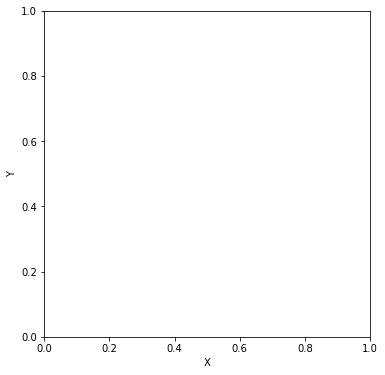

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.imshow(data_loader.dataset[0][0], cmap='gray')

[sizing for hyperparameters](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)
$$
O = \frac{I - F + P_{\text{start}} + P_{\text{end}}}{S} + 1
$$

torch.nn.**Conv2d**(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

For rectangular image, with floor function

H(out)=⌊ [H(in)+2×padding[0]−dilation[0]×(kernel_size[0]−1)−1] / stride[0] + 1 ⌋

W(out)=⌊ [W(in)+2×padding[1]−dilation[1]×(kernel_size[1]−1)−1] / stride[1] + 1 ⌋

torch.nn.**ConvTranspose2d**(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)

For rectangular image,

H(out)=(H(in)−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1

W(out)=(W(in)−1)×stride[1]−2×padding[1]+dilation[1]×(kernel_size[1]−1)+output_padding[1]+1

In [ ]:
class Autoencoder(nn.Module):

  def __init__(self):
    super().__init__()
    # N, 1, 28, 28
    self.encoder = nn.Sequential(
        # floor((28-3+1+1)/2 + 1) = 14
        nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
        nn.ReLU(),
        # floor((14-3+1+1)/2 + 1) = 7
        nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
        nn.ReLU(),
        # floor((7-3+1+1)/7 + 1) = 1
        nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
    )

    # N, 64, 1, 1
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # -> N, 16, 13+1, 13+1
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # -> N, 1, 27+1, 27+1
        nn.Sigmoid() # since min=0. max=1.
        # other possible options for different data range:
        # nn.Tanh if [-1,1]
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# other ways to reduce the size nn.MaxPool2d <-> nn.MaxUnPool2d

In [ ]:
model = Autoencoder()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

model

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [ ]:
num_epochs = 50
outputs = []
for epoch in range(num_epochs):
  for batch in data_loader:
    img = batch[0] # img.shape = torch.Size([batch_size = 16, 1, 28, 28])
    recon = model(img)
    loss = loss_fn(recon, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')
  outputs.append((epoch, img, recon))

Epoch: 1, Loss: 0.1292
Epoch: 2, Loss: 0.0963
Epoch: 3, Loss: 0.0493
Epoch: 4, Loss: 0.0499
Epoch: 5, Loss: 0.0413
Epoch: 6, Loss: 0.0276
Epoch: 7, Loss: 0.0402
Epoch: 8, Loss: 0.0319
Epoch: 9, Loss: 0.0240
Epoch: 10, Loss: 0.0147
Epoch: 11, Loss: 0.0149
Epoch: 12, Loss: 0.0157
Epoch: 13, Loss: 0.0070
Epoch: 14, Loss: 0.0139
Epoch: 15, Loss: 0.0241
Epoch: 16, Loss: 0.0167
Epoch: 17, Loss: 0.0097
Epoch: 18, Loss: 0.0130
Epoch: 19, Loss: 0.0150
Epoch: 20, Loss: 0.0158
Epoch: 21, Loss: 0.0171
Epoch: 22, Loss: 0.0115
Epoch: 23, Loss: 0.0146
Epoch: 24, Loss: 0.0083
Epoch: 25, Loss: 0.0102
Epoch: 26, Loss: 0.0102
Epoch: 27, Loss: 0.0101
Epoch: 28, Loss: 0.0091
Epoch: 29, Loss: 0.0079
Epoch: 30, Loss: 0.0093
Epoch: 31, Loss: 0.0118
Epoch: 32, Loss: 0.0091
Epoch: 33, Loss: 0.0073
Epoch: 34, Loss: 0.0068
Epoch: 35, Loss: 0.0066
Epoch: 36, Loss: 0.0059
Epoch: 37, Loss: 0.0100
Epoch: 38, Loss: 0.0078
Epoch: 39, Loss: 0.0051
Epoch: 40, Loss: 0.0050
Epoch: 41, Loss: 0.0059
Epoch: 42, Loss: 0.0064
E

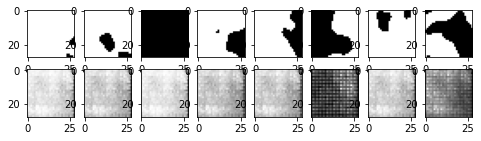

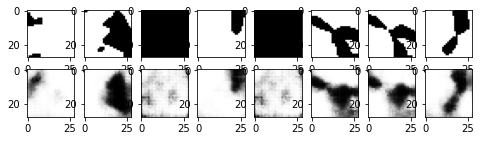

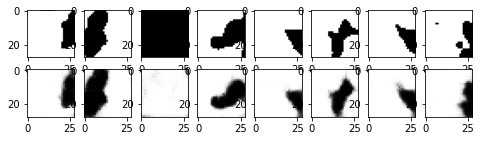

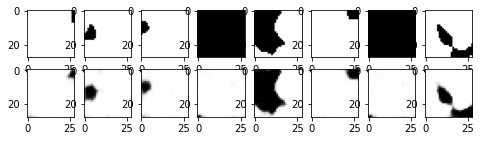

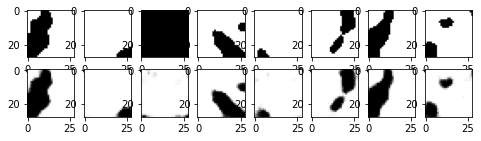

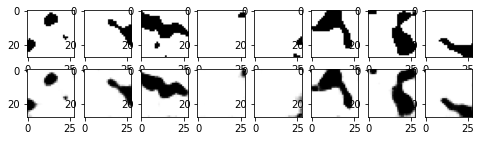

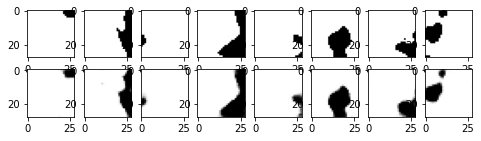

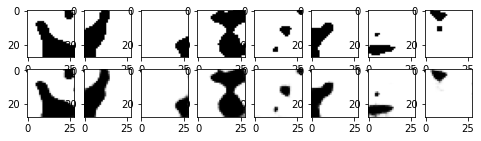

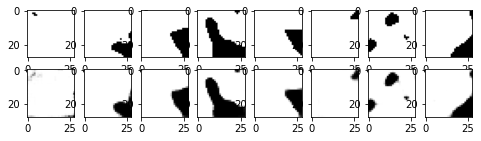

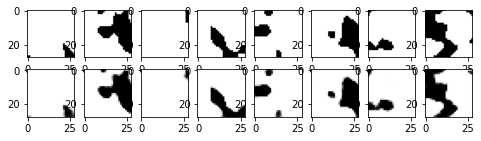

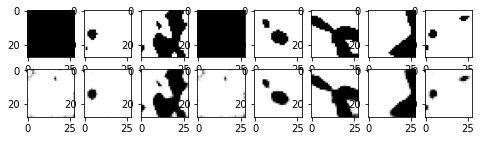

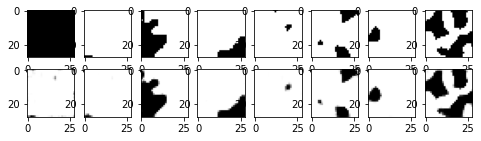

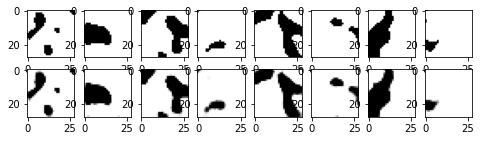

In [ ]:
for k in range(0, num_epochs, 4):
  plt.figure(figsize=(9,2))
  plt.gray()
  imgs = outputs[k][1].detach().numpy()
  recon = outputs[k][2].detach().numpy()
  # plot the first of 32 images
  for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2,9,i+1)
    plt.imshow(item[0])
  
  for i, item in enumerate(recon):
    if i >= 9: break
    plt.subplot(2,9, 9+i+1) # in the second line
    plt.imshow(item[0])